<a href="https://colab.research.google.com/github/VorkovN/QLearningCartPole/blob/main/QLearningExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq ipdb
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
%matplotlib inline
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import ipdb
import random, math
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

from IPython.display import clear_output
from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
device: cpu


eps = 0.5 mean reward = 13.37
alpha= 0.7


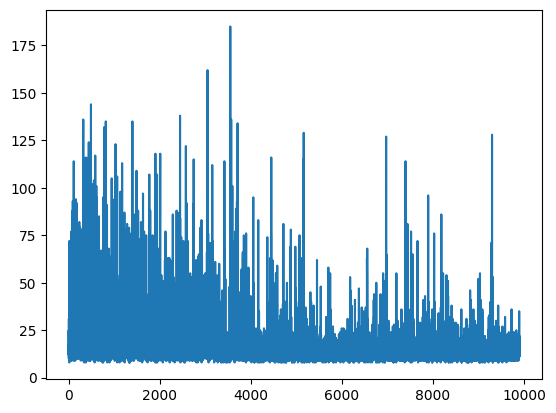

In [ ]:
ALPHA=0.7
EPSILON=0.5
GAMMA=0.98

class QLearningAgent():
    def __init__(self):

        self.alpha = ALPHA
        self.epsilon = EPSILON
        self.gamma = GAMMA

        ##q-table на каждой задачу подбирается руками исходя из логики и здравого смысла
        actions_frame = np.array([2]).astype(int)           # подбор пространства возможных действий
        states_frame = np.array([1, 7, 7, 10]).astype(int)   # подбор пространства возможных состояний

        actions_count = np.prod(actions_frame)
        states_count = np.prod(states_frame)

        # каждая строка представляет одну из возможных комбинаций всех состояний
        # каждый столбец представляет одну из возможных комбинаций всех действий
        self.q_table = np.zeros((states_count, actions_count)) # zeros or ones
        self.actions_bounds = np.array((actions_frame, np.zeros((actions_frame.size)), np.zeros((actions_frame.size)))).transpose()
        self.states_bounds = np.array((states_frame, np.zeros((states_frame.size)), np.zeros((states_frame.size)))).transpose()

        self.actions_bounds[0][1] = 0 # шаг влево
        self.actions_bounds[0][2] = 1 # шаг вправо

        self.states_bounds[0][1]=-4.8
        self.states_bounds[0][2]=4.8

        self.states_bounds[1][1]=-10
        self.states_bounds[1][2]=10

        self.states_bounds[2][1]=-0.21
        self.states_bounds[2][2]=0.21

        self.states_bounds[3][1]=-10
        self.states_bounds[3][2]=10

    def __get_actions_vector(self, action_cell_index):
        
        discrete_actions_vector = np.zeros((self.actions_bounds.shape[0]))

        for i in reversed(range(0, discrete_actions_vector.shape[0])):
          cell_multtiplier = 1
          for j in range(0, i+1):
            if (i != j):
              cell_multtiplier*=self.actions_bounds[j][0]
            else:
              discrete_actions_vector[i] = float(action_cell_index) / cell_multtiplier
              action_cell_index = action_cell_index % cell_multtiplier

        permanent_actions_vector = np.zeros((self.actions_bounds.shape[0]))
        for i in range(0, discrete_actions_vector.shape[0]):
          permanent_actions_vector[i] = discrete_actions_vector[i] * (self.actions_bounds[i][2] - self.actions_bounds[i][1]) + self.actions_bounds[i][1]

        return permanent_actions_vector


    def __get_q_index(self, elements_vector, elements_bounds):
      
        clipped_state = np.zeros((elements_vector.size)).astype(int)

        for i in range(0, elements_vector.shape[0]):
          lower_bound, upper_bound = elements_bounds[i][1], elements_bounds[i][2]
          if elements_vector[i] <= lower_bound:
              clipped_state[i] = 0
          elif elements_vector[i] >= upper_bound:
              clipped_state[i] = elements_bounds[i][0] - 1
          else:
              clipped_state[i] = ((elements_vector[i]-lower_bound)/(upper_bound-lower_bound)) * elements_bounds[i][0]

        #todo размножить эту функцию
        cell_index = 0;
        for i in range(0, clipped_state.shape[0]):
          cell_multtiplier = clipped_state[i]
          for j in range(0, i+1):
            if (i != j):
              cell_multtiplier*=elements_bounds[j][0]
            else:
              cell_index += cell_multtiplier

        return cell_index


    # Стратегия нашего агента будет заключаться в выборе лучшего действия, в соответствии с оценками  𝑄 
    def __get_policy(self, state_cell_index):
        
        possible_actions_vector = self.q_table[state_cell_index] # обращение к нужному вектору возможных действий
        
        best_action_cell_index = int(-1)
        for action_cell_index in range(possible_actions_vector.shape[0]):
            if best_action_cell_index == -1:
                best_action_cell_index = action_cell_index
            elif self.q_table[state_cell_index][best_action_cell_index] < self.q_table[state_cell_index][action_cell_index]:
                best_action_cell_index = action_cell_index

        return best_action_cell_index


    # Для конкретной ситуации мы будем выбирать действие, используя e-жадный подход
    def get_action(self, state_vector):

        state_cell_index = int(self.__get_q_index(state_vector, self.states_bounds)) # поиск индекса q-table ячейки с нужным состоянием
        if np.random.random() < self.epsilon:
            possible_actions_vector = self.q_table[state_cell_index] # обращение к нужному вектору возможных действий
            action_cell_index = random.randint(0, possible_actions_vector.size-1)
            # ipdb.set_trace(context=12)
        else:
            action_cell_index = self.__get_policy(state_cell_index)
            
        x = self.__get_actions_vector(action_cell_index)
        return x


    # Функция Q-обновления
    def update(self, state_vector, action_vector, next_state_vector, reward):

        action_cell_index = self.__get_q_index(action_vector, self.actions_bounds)
        state_cell_index = int(self.__get_q_index(state_vector, self.states_bounds))
        next_state_cell_index = int(self.__get_q_index(next_state_vector, self.states_bounds))

        max_qvalue = self.q_table[next_state_cell_index].max()
        qvalue = self.q_table[state_cell_index][action_cell_index]

        reference_qvalue = qvalue + self.alpha*(reward + self.gamma * max_qvalue - qvalue)
        self.q_table[state_cell_index][action_cell_index] = reference_qvalue


%pdb on


STEPS_MAX = 200
EPISIDES_MAX = 10000

env = gym.make('CartPole-v1')
state = env.reset()
state
agent = QLearningAgent()

rewards = []
for i in range(EPISIDES_MAX):

    total_reward = 0.0
    state = env.reset()
    
    for step in range(STEPS_MAX):
        # выбираем действие
        
        action = agent.get_action(state).astype(int)# если действие дискретное, то нужно руками смкастить в инт
        
        next_s, reward, done, _ = env.step(action[0])# если пространство действий одномерно, то привести массив к размерности 1
        
        # выполняем обновление стратегии
        agent.update(state, action, next_s, reward)
        
        state = next_s
        total_reward +=reward
        if done:
            break
        
    rewards.append(total_reward)

    if i % 100 == 0:
    # print('reward {}'.format(total_reward))
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-100:]))
        print("alpha=", agent.alpha)
        plt.plot(rewards)
        plt.show()